# **Model Designing**



## **Packages, parameters**

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from PIL import Image
from tqdm import tqdm

import torch
import torch.optim as opt
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [41]:
device

device(type='cuda')

In [81]:
# hyperparameters
SIZE_MIN = 256
SIZE_MAX = 512

BATCH_SIZE = 5
EPOCH = 1
LEARNING_RATE = 0.0002

# dictionary for classification
dict_class = {
    'action': ['bodylower', 'bodyscratch', 'bodyshake', 'feetup', 'footup', 'heading', 'lying', 'mounting', 'sit', 'tailing', 'taillow', 'turn', 'walkrun'],
    'emotion': ['aggresive', 'feared', 'anxiety', 'relaxed', 'excited', 'offended'],
}

## **Utility functions**

In [12]:
# custom collate function for variable-size input
def my_collate(batch):
    return {
        'image': [item['image'] for item in batch],                         # list of tensors [B]: (tensor) [3, H, W]
        'seq': torch.tensor([item['seq'] for item in batch]),               # [B]
        'frame_idx': torch.tensor([item['frame_idx'] for item in batch]),   # [B]
        'action': torch.tensor([item['action'] for item in batch]),         # [B]
        'emotion': torch.tensor([item['emotion'] for item in batch]),       # [B]
        'bbox': torch.stack([item['bbox'] for item in batch]),              # [B, 4]
        'keypoints': torch.stack([item['keypoints'] for item in batch]),    # [B, 15, 3]
    }

In [13]:
def visualize(
    num_image: int = 1,
    fig_size: int = 9,
    images: list = None,
    bbox: list = None,
    keypoints: list = None,
) -> None:
    fig = plt.figure(figsize=(fig_size, fig_size))
    cols = math.ceil(math.sqrt(num_image))
    rows = num_image // cols + 1

    for i in range(num_image):
        x1, y1, x2, y2 = bbox[i]
        key = keypoints[i]

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].permute(1, 2, 0))
        ax.add_patch(patches.Rectangle(
            (x1, y1),
            x2-x1,
            y2-y1,
            color='w',
            alpha=0.2,
            fill=True,))
        ax.add_patch(patches.Rectangle(
            (x1, y1),
            x2-x1,
            y2-y1,
            color='c',
            linewidth=2,
            fill=False,))
        for k in key:
            if not k[-1]:
                continue
            ax.plot(k[0], k[1], 'ro', ms=3)
        ax.axis('off')

## **Dataloader**

In [15]:
class DogDataset(Dataset):
    def __init__(self, img_dir, label, transform=None):
        self.img_dir = img_dir
        self.label = pd.read_csv(label)
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image = ToTensor()(Image.open(os.path.join(self.img_dir, self.label.iloc[idx, 0])))
        sample = { 'image': image }
        sample.update(self.label.iloc[idx, 1:])
        sample['bbox'] = torch.FloatTensor(eval(sample['bbox']))
        sample['keypoints'] = torch.FloatTensor(eval(sample['keypoints']))
        return sample

In [16]:
train_dataset = DogDataset(
    'train/',
    'label.csv',
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=my_collate,
    shuffle=True,
)

In [17]:
train_img = next(iter(train_dataloader))

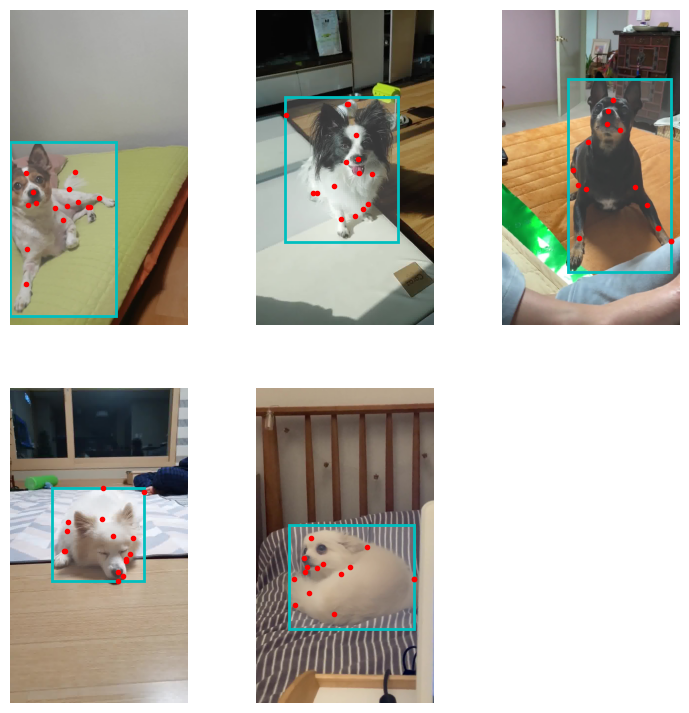

In [19]:
visualize(
    num_image=BATCH_SIZE,
    fig_size=9,
    images=train_img['image'],
    bbox=list(train_img['bbox']),
    keypoints=list(train_img['keypoints']),
)

## **Pose Estimation: Using Keypoint R-CNN**
    - Backbone: ResNet34; FPN extracted
    - Input: ...
    - Output: ...

### Download model

In [20]:
import torchvision.models.detection.keypoint_rcnn as krcnn
from torchvision.models.resnet import ResNet34_Weights, resnet34
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor

In [21]:
backbone = resnet34(weights=ResNet34_Weights.DEFAULT)
backbone = _resnet_fpn_extractor(backbone, 3) #trainable layer: 3

model_PE = krcnn.KeypointRCNN(
    backbone=backbone,
    num_classes=2,
    min_size=SIZE_MIN,
    max_size=SIZE_MAX,
    num_keypoints=15,)

### Pre-Test and Visualize

In [22]:
model_PE.to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, moment

In [72]:
model_PE.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, moment

In [73]:
p = model_PE([x.to(device) for x in train_img['image']])

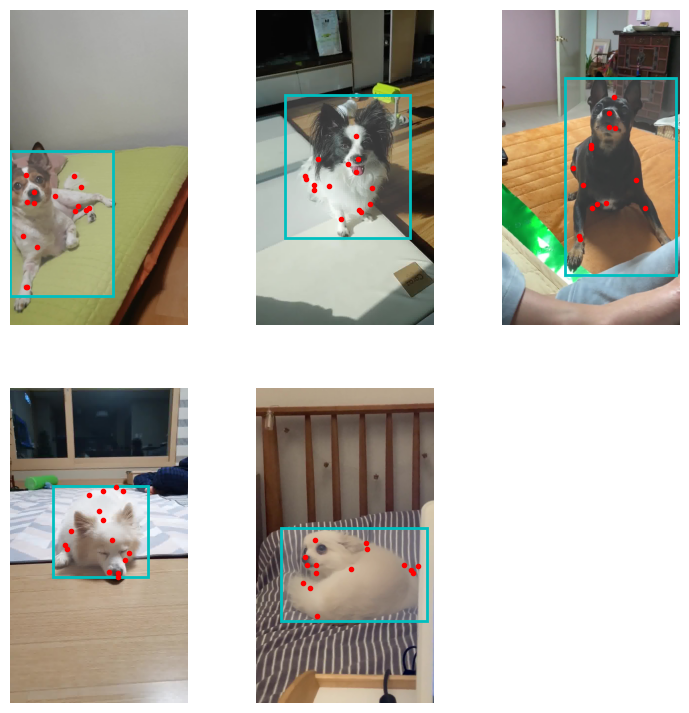

In [74]:
with torch.no_grad():
    visualize(
        num_image=BATCH_SIZE,
        fig_size=9,
        images=train_img['image'],
        bbox=[x['boxes'][0].cpu() for x in p],
        keypoints=[x['keypoints'][0].cpu() for x in p],
    )

### Training

In [28]:
model_PE.train()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, moment

In [82]:
optimizer = opt.Adam(model_PE.parameters(), lr=LEARNING_RATE)

In [59]:
loss_train = []

for e in range(EPOCH):
    for data in tqdm(train_dataloader):
        optimizer.zero_grad()
        
        image = [x.to(device) for x in data['image']]
        target = [{
            'boxes': data['bbox'][i].unsqueeze(0).to(device),
            'labels': torch.ones(1, dtype=torch.long, device=device),
            'keypoints': data['keypoints'][i].unsqueeze(0).to(device),
        } for i in range(len(data['image']))]
        
        loss = sum(model_PE(image, target).values())
        loss.backward()
        optimizer.step()
        loss_train.append(loss)

100%|███████████████████████████████████████████████████████████████████████████████▉| 945/946 [05:54<00:00,  2.66it/s]


IndexError: index 3 is out of bounds for dimension 0 with size 3

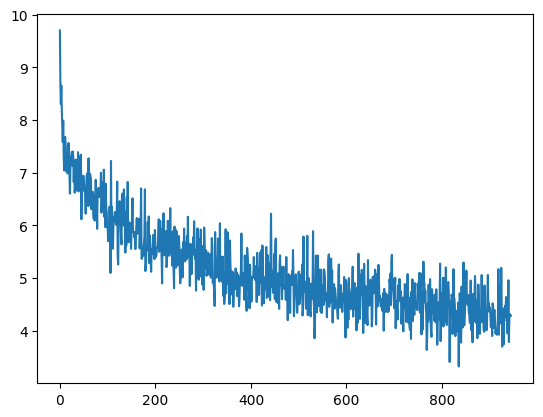

In [64]:
with torch.no_grad():
    plt.plot([x.cpu() for x in loss_train])

In [80]:
torch.save(model_PE.state_dict(), 'state/test_ep1')

# Memo